In [1]:
# Parameters
DatasetID = "DS000017114"
DEV = False
test_DatasetID = ""
DS_test = False
title = "Recursion DLD1 Library1 Screen Day 5- combination of NGS 5774 and NGS 5702"
description = "Production scale screen in DLD-1 cells with 1/4 of the genome-wide CRISPR library (sub-lib-1, ~22K guides). 1 time point: Day-5. We performed 24 rxns of 10x 3' HT kit with an estimated loading of 52K cells. We performed a pilot study to test the library quality before the production-level sequencing. We will submit 72 libraries (24 GEX, 24 HTO and 24 sgRNA) We estimate need 600M for GEX, 30M for HTO and 50M for sgRNA. This is a repeat run to correct chip loading."
name_space = [{"id": "GRCh38", "type": "genome"}]
sources = [{"id": "Siavash-1234", "name": "Geo-ID"}]
tech_name = "scRNA-seq"
author = "SG"
organism = "human"
groupby = "Sample"
min_cells = 3
min_genes = 500
max_genes = None
pct_mt = None
total_counts = None
n_top_genes = 2000
ribo = True
doublets = True
subsample_dic = {}
subsample_type = "n"
Dataset_Home = "/gstore/project/crc_recursion_gw/DLD1_Sublib1_bdev//DS000017114"
out_norm = "/gstore/project/crc_recursion_gw/DLD1_Sublib1_bdev//DS000017114/test_norm"
out_embeddings = "/gstore/project/crc_recursion_gw/DLD1_Sublib1_bdev//DS000017114/Embeddings"
raw_qc = "/gstore/project/crc_recursion_gw/DLD1_Sublib1_bdev//DS000017114/raw_qc.h5ad"
raw_embedding = "/gstore/project/crc_recursion_gw/DLD1_Sublib1_bdev//DS000017114/qc_embedding.h5ad"


 # Create embeddings for future analayis: this notebook will create embedding of our anndata object ad store it

#### Please insert your inputs

In [2]:
DSID = DatasetID
your_experiment = "raw_qc" # A string that is a key known for our desired experimnet that you wish to work on
Version = '1'

In [3]:
#single cell libraries
import scanpy as sc
import matplotlib.pyplot as plt

#general
import pickle
from scipy.sparse import csr_matrix
import os
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#plotting
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append("..")
import Templates.tools.DatasetDB as DB
import Templates.tools.RNA_Seq_QC as rnaqc
import Templates.tools.scProc as proc
"""
try:
    import Templates.tools.rapids_modified as rp
except ImportError:
        pass
"""

'\ntry:\n    import Templates.tools.rapids_modified as rp\nexcept ImportError:\n        pass\n'

In [5]:
import Templates.tools.rapids_modified as rp

In [6]:
%load_ext autoreload
%autoreload 2

### Check if GPU device is available 

In [7]:
GPU = rnaqc.pipeline_has_gpu()

In [8]:
GPU

True

## Instantiate a dataset object given our dataset info

In [9]:
#DS = DB.DATASET(DSID, DEV, title=title, description=description, name_space=name_space, organism=organism,
#                       sources=sources, tech_name=tech_name, author=author)

In [10]:
#adata, adatas = DS.load_dataset(Version, your_experiment, Corr=False)

In [11]:
#adata = rnaqc.load_data(adata)

In [12]:
adata = sc.read(raw_qc)

### Create gem column from NGS_ID and 10xrun

In [13]:
adata.obs['gem'] = adata.obs['NGS_ID'].astype(str) + '-' + adata.obs['10Xrun'].astype(str)

In [14]:
adata.obs.head()

,Sample,Barcode,DemuxType_crispr,DemuxAssignment_crispr,DemuxType_hashing,DemuxAssignment_hashing,cellline,timepoint,HTO,NGS_ID,...,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,qc_pass,S_score,G2M_score,phase,SCN_class,gem
SAM24451293_rep1-AAACCCAAGAAATCCA,SAM24451293,AAACCCAAGAAATCCA,singlet,ENSG00000154124_2,singlet,SAM24439044,DLD1,day5,HTO-14,NGS5774,...,534,3.448721,3024,19.529837,True,-0.734884,-0.491440,G1,Untreatedclus_DLD1,NGS5774-1
SAM24451293_rep1-AAACCCAAGACAGTCG,SAM24451293,AAACCCAAGACAGTCG,singlet,ENSG00000171017_3,singlet,SAM24439045,DLD1,day5,HTO-18,NGS5774,...,618,6.336512,2152,22.065006,True,-0.493023,0.231481,G2M,Untreatedclus_DLD1,NGS5774-1
SAM24451293_rep1-AAACCCACAGACCCGT,SAM24451293,AAACCCACAGACCCGT,singlet,ENSG00000140057_1,singlet,SAM24439043,DLD1,day5,HTO-10,NGS5774,...,380,3.150912,1794,14.875622,True,-0.158140,-0.564640,G1,Untreatedclus_DLD1,NGS5774-1
SAM24451293_rep1-AAACCCAGTAACGATA,SAM24451293,AAACCCAGTAACGATA,singlet,ENSG00000188611_3,singlet,POSITIVE_CONTROL,DLD1,day5,HTO-19,NGS5774,...,316,4.564495,1732,25.018056,True,-0.520930,-0.385045,G1,Untreatedclus_DLD1,NGS5774-1
SAM24451293_rep1-AAACCCAGTACGACAG,SAM24451293,AAACCCAGTACGACAG,singlet,ENSG00000166664_2,singlet,SAM24439043,DLD1,day5,HTO-1,NGS5774,...,638,4.482541,2507,17.613996,True,0.334884,-0.072851,S,Untreatedclus_DLD1,NGS5774-1


In [15]:
adata.var.head()

,Symbol
3xLinker,3xLinker
MIR1302-2HG,MIR1302-2HG
FAM138A,FAM138A
OR4F5,OR4F5
AL627309.1,AL627309.1


## Instantiate a RapidsSingleCellPipeline object given our AnnData to prepare RAPIDS environment for other steps

In [16]:
RP = rp.RapidsSingleCellPipeline(adata)

## Notice: 
- **RP._adata is adata before filtering** 
- **RP.adata_ is adata after filtering**
- **Rp.adata is adata after normalization (and highly variable genes selected)**

## Run Normalize -> HGV -> PCA -> kNN -> Leiden -> UMAP 

In [17]:
RP.proc(2000, norm=True, scale=True, regress=False, embedding=True,
                 n_components=50, n_neighbors=10, knn_n_pcs=30, batch_key=None, filtered= False)

Filtering cells.


Processed 0 cells..


Processed 100000 cells..


Processed 200000 cells..


Processed 300000 cells..


Processed 400000 cells..


Processed 500000 cells..


Filtering genes and normalizing data.


Completed preprocessing.


Converting sparse GPU array to dense GPU array.


Preprocessing took 381.1208188533783 seconds


scaling


scaling took 18.53619933128357 seconds
computing PCA


PCA took 14.071202516555786 seconds


kNN took 16.639118671417236 seconds
computing UMAP


UMAP took 6.837902784347534 seconds
computing Leiden clustering


Leiden clustering took 0.5910394191741943 seconds


In [18]:
RP.adata.var

""
HES4
ISG15
AURKAIP1
MRPL20
SSU72
...
MT-ND4L
MT-ND4
MT-ND5
MT-ND6


## Plot PCA UMAP

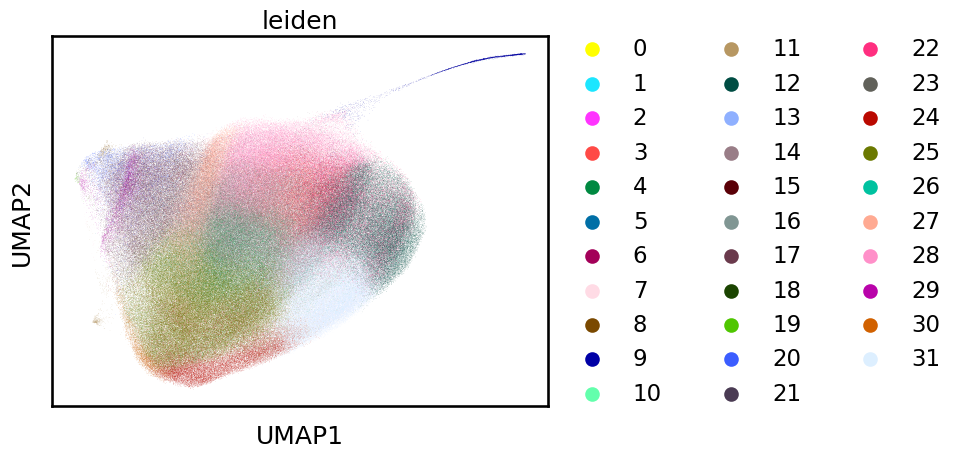

In [19]:
if GPU:
    sc.pl.umap(RP.adata, color="leiden")

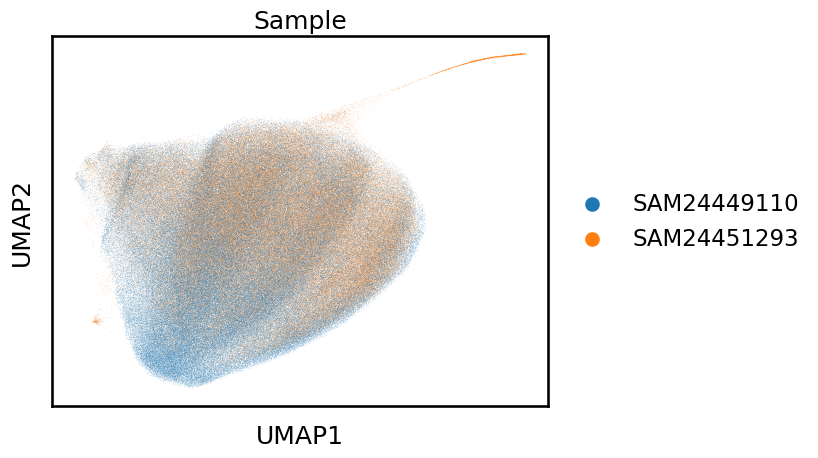

In [20]:
if GPU:
    sc.pl.umap(RP.adata, color=groupby, cmap=plt.get_cmap('viridis'))

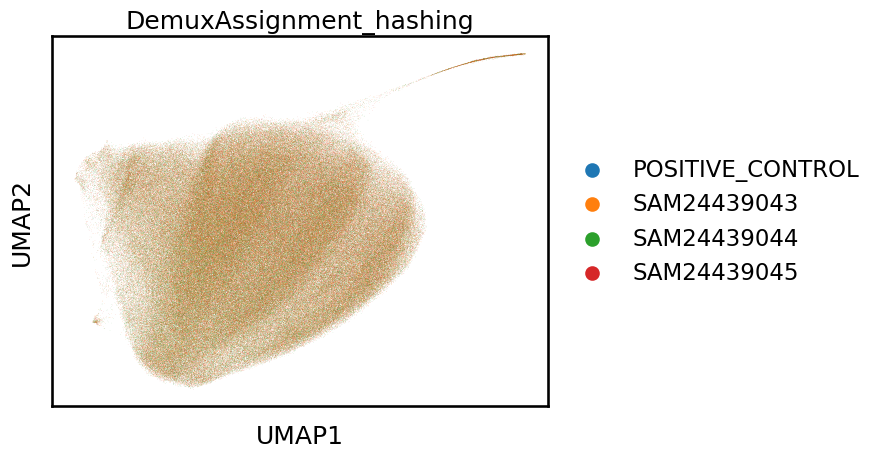

In [21]:
if GPU:
    sc.pl.umap(RP.adata, color="DemuxAssignment_hashing", cmap=plt.get_cmap('viridis'))

## Batch Correction (scVI)

In [22]:
Batch_needed = True

In [23]:
if Batch_needed:
    RP.run_scvi(counts_layer = "counts", batch_key = "gem")

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/13:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/13:   8%|▊         | 1/13 [00:35<07:11, 35.92s/it]

Epoch 1/13:   8%|▊         | 1/13 [00:35<07:11, 35.92s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.32e+3]

Epoch 2/13:   8%|▊         | 1/13 [00:35<07:11, 35.92s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.32e+3]

Epoch 2/13:  15%|█▌        | 2/13 [01:15<06:55, 37.78s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.32e+3]

Epoch 2/13:  15%|█▌        | 2/13 [01:15<06:55, 37.78s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.1e+3] 

Epoch 3/13:  15%|█▌        | 2/13 [01:15<06:55, 37.78s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.1e+3]

Epoch 3/13:  23%|██▎       | 3/13 [01:50<06:07, 36.73s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.1e+3]

Epoch 3/13:  23%|██▎       | 3/13 [01:50<06:07, 36.73s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 4/13:  23%|██▎       | 3/13 [01:50<06:07, 36.73s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 4/13:  31%|███       | 4/13 [02:28<05:35, 37.28s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 4/13:  31%|███       | 4/13 [02:28<05:35, 37.28s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 5/13:  31%|███       | 4/13 [02:28<05:35, 37.28s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 5/13:  38%|███▊      | 5/13 [03:04<04:54, 36.83s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 5/13:  38%|███▊      | 5/13 [03:04<04:54, 36.83s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 6/13:  38%|███▊      | 5/13 [03:04<04:54, 36.83s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 6/13:  46%|████▌     | 6/13 [03:41<04:17, 36.78s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 6/13:  46%|████▌     | 6/13 [03:41<04:17, 36.78s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 7/13:  46%|████▌     | 6/13 [03:41<04:17, 36.78s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 7/13:  54%|█████▍    | 7/13 [04:19<03:42, 37.10s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 7/13:  54%|█████▍    | 7/13 [04:19<03:42, 37.10s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 8/13:  54%|█████▍    | 7/13 [04:19<03:42, 37.10s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 8/13:  62%|██████▏   | 8/13 [04:54<03:03, 36.64s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 8/13:  62%|██████▏   | 8/13 [04:54<03:03, 36.64s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 9/13:  62%|██████▏   | 8/13 [04:54<03:03, 36.64s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 9/13:  69%|██████▉   | 9/13 [05:31<02:27, 36.76s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 9/13:  69%|██████▉   | 9/13 [05:31<02:27, 36.76s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 10/13:  69%|██████▉   | 9/13 [05:31<02:27, 36.76s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 10/13:  77%|███████▋  | 10/13 [06:07<01:49, 36.35s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 10/13:  77%|███████▋  | 10/13 [06:07<01:49, 36.35s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 11/13:  77%|███████▋  | 10/13 [06:07<01:49, 36.35s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 11/13:  85%|████████▍ | 11/13 [06:45<01:13, 36.97s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 11/13:  85%|████████▍ | 11/13 [06:45<01:13, 36.97s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 12/13:  85%|████████▍ | 11/13 [06:45<01:13, 36.97s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 12/13:  92%|█████████▏| 12/13 [07:22<00:37, 37.10s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 12/13:  92%|█████████▏| 12/13 [07:22<00:37, 37.10s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 13/13:  92%|█████████▏| 12/13 [07:22<00:37, 37.10s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 13/13: 100%|██████████| 13/13 [07:58<00:00, 36.64s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 13/13: 100%|██████████| 13/13 [07:58<00:00, 36.64s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

`Trainer.fit` stopped: `max_epochs=13` reached.


Epoch 13/13: 100%|██████████| 13/13 [07:58<00:00, 36.81s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Scvi Training took 492.88409399986267 seconds


In [24]:
if Batch_needed:
    RP.run_knn(n_neighbors=30, knn_n_pcs=30, use_rep='X_scVI')

kNN took 36.51664447784424 seconds


In [25]:
RP.run_umap(umap_min_dist= 0.3, umap_spread=1.0)

UMAP took 9.670418977737427 seconds


In [26]:
RP.run_leiden()

Leiden clustering took 1.3116981983184814 seconds


## Plot PCA UMAP after batch correction (scVI)

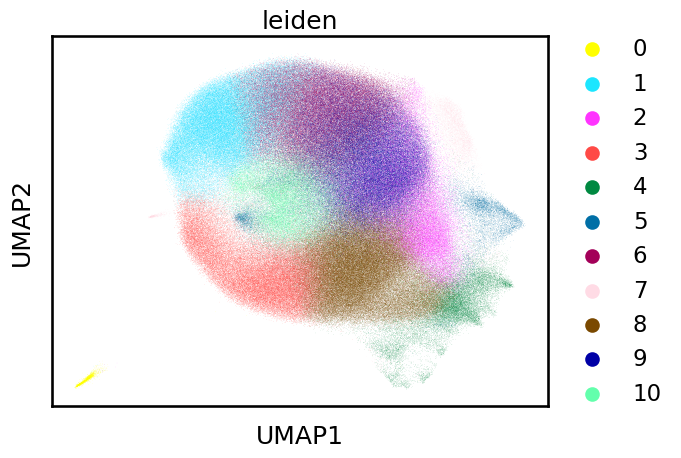

In [27]:
if Batch_needed:
    sc.pl.umap(RP.adata, color="leiden")

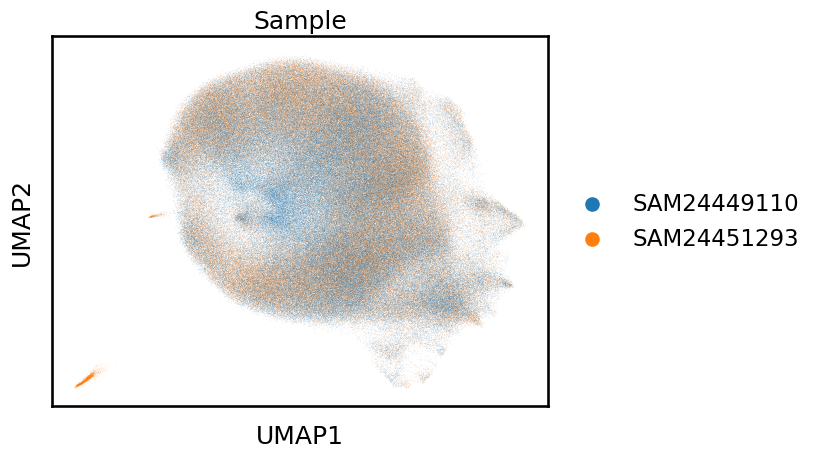

In [28]:
if Batch_needed:
    sc.pl.umap(RP.adata, color=groupby)

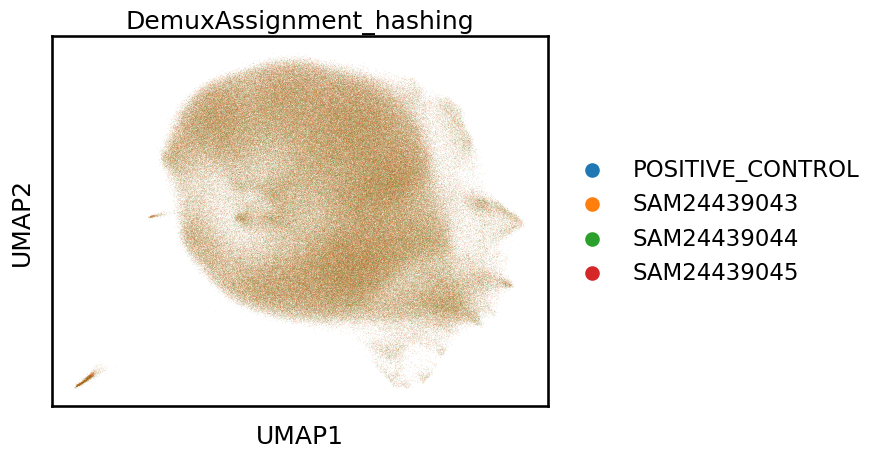

In [29]:
if Batch_needed:
    sc.pl.umap(RP.adata, color="DemuxAssignment_hashing")

## Batch Correction (harmony)

In [30]:
#if Batch_needed:
#    RP.run_harmony(batch_key = "gem")

In [31]:
#if Batch_needed:
#    RP.run_knn(n_neighbors=30, knn_n_pcs=30, use_rep='X_harmony')

In [32]:
#RP.run_umap(umap_min_dist= 0.3, umap_spread=1.0)

In [33]:
#RP.run_leiden()

## Plot PCA UMAP after batch correction (harmony)

In [34]:
#if Batch_needed:
#    sc.pl.umap(RP.adata, color="leiden")

In [35]:
#if Batch_needed:
#    sc.pl.umap(RP.adata, color=groupby)

In [36]:
#if Batch_needed:
#    sc.pl.umap(RP.adata, color="DemuxAssignment_hashing")

In [37]:
if GPU==False:
    adata_tmp = proc.proc(adata_tmp, 'auto', norm=True, scale=True, regress=False, embedding=True)
    sc.pl.umap(adata_tmp, color=groupby)

## Centering the embeddings at NTC

### PCA

In [38]:
proc.centered_embedding_adata(
            RP.adata,
            'X_pca',
            'gene_symbol',
      'DemuxAssignment_crispr',
            "NTC",
pool_ntcs=False)

### scVI

In [39]:
proc.centered_embedding_adata(
            RP.adata,
            'X_scVI',
            'gene_symbol',
      'DemuxAssignment_crispr',
            "NTC",
pool_ntcs=False)

In [40]:
### harmony

In [41]:
"""
proc.centered_embedding_adata(
            RP.adata,
            'X_harmony',
            'gene_symbol',
      'DemuxAssignment_crispr',
            "NTC",
pool_ntcs=False)
"""

'\nproc.centered_embedding_adata(\n            RP.adata,\n            \'X_harmony\',\n            \'gene_symbol\',\n      \'DemuxAssignment_crispr\',\n            "NTC",\npool_ntcs=False)\n'

### Whitening PCA

In [42]:
#RP.run_pca_whitened(n_components=50)

### Sphering PCA

In [43]:
proc.run_sphering_transform(RP.adata, query="gene_symbol == 'NTC'", reg_param=1e-3)

AnnData object with n_obs × n_vars = 595603 × 2000
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'gem', 'leiden', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap', 'leiden_colors', 'Sample_colors', 'DemuxAssignment_hashing_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI', 'X_pca_centered', 'X_scVI_centered', 'X_pca_sphered'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [44]:
RP.adata_

AnnData object with n_obs × n_vars = 595603 × 36603
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'gem'
    var: 'Symbol'
    layers: 'counts'

In [45]:
RP.adata

AnnData object with n_obs × n_vars = 595603 × 2000
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'HTO', 'NGS_ID', 'Biological_replicate', '10Xrun', 'sublibrary', 'gRNA_library_MOI', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'qc_pass', 'S_score', 'G2M_score', 'phase', 'SCN_class', 'gem', 'leiden', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap', 'leiden_colors', 'Sample_colors', 'DemuxAssignment_hashing_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI', 'X_pca_centered', 'X_scVI_centered', 'X_pca_sphered'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [46]:
RP.adata.var

""
HES4
ISG15
AURKAIP1
MRPL20
SSU72
...
MT-ND4L
MT-ND4
MT-ND5
MT-ND6


In [47]:
"""
adatas_updated = {}
if GPU:
    adata_updated = RP.adata_.copy()
else:
    adata_updated = adata.copy()
"""

'\nadatas_updated = {}\nif GPU:\n    adata_updated = RP.adata_.copy()\nelse:\n    adata_updated = adata.copy()\n'

### Write h5ad version on the disk

In [48]:
# If you wish to write on the disk
#adata_updated.var.index.name = None
#adata_updated.write_h5ad(raw_qc)

## Write h5ad file with embedings for Energy Distance analaysis

In [49]:
RP.adata_.obsp = RP.adata.obsp.copy()
RP.adata_.obsm = RP.adata.obsm.copy()
RP.adata_.uns = RP.adata.uns.copy()

### Extract BDEV list which comes handy for later

In [50]:
BDEV_path = os.path.join(Dataset_Home, f'BDEV_2000.pkl')

In [51]:
with open(BDEV_path, "rb") as fp:   # Unpickling
        BDEV = pickle.load(fp)

### Store log scaled  counts

In [52]:
RP.run_normalize()

Processed 0 cells..


Processed 100000 cells..


Processed 200000 cells..


Processed 300000 cells..


Processed 400000 cells..


Processed 500000 cells..


normalizing data.


Completed preprocessing.


Preprocessing took 205.26557278633118 seconds


In [53]:
RP.adata_.layers['log_norm'] = RP.adata.layers['counts']

In [54]:
if GPU:
    adata_embedding = RP.adata_.copy()
else:
    adata_embedding = adata_tmp.copy()  

In [55]:
adata_embedding.X = adata_embedding.X.astype("float32")
adata_embedding.layers['counts'] = adata_embedding.layers['counts'].astype("float32")

## Create Control_norm big Matrix

In [56]:
out_norm = "/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/"

In [57]:
folder_paths = [out_norm]

In [58]:
adata_norm = proc.concat_norm_matrix(BDEV, folder_paths)

/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-18.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-13.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-1.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-21.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-2.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-10.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-6.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-14.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-14.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-13.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-6.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-21.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-7.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-5.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-8.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-9.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-5.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-24.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-4.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-7.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-4.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-19.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-3.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-23.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-24.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-16.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-12.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-19.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-9.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-17.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-10.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-2.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-22.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-15.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-22.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-8.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-18.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-16.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-11.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-20.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-12.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-23.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-11.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-1.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-20.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-15.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5774-3.h5ad


/gstore/scratch/u/ghaffars/Dataset/sublib1/test_norm/NGS5702-17.h5ad


## Reindex the Norm adata

In [59]:
#adata_norm = adata_norm[RP.adata_.obs.index.copy()].copy()

In [60]:
#adata_norm.obs

In [61]:
#RP.adata_.obs

## Check If the reindexing is true

In [62]:
#adata_norm.obs.index.to_list() == RP.adata_.obs.index.to_list()

## Calculate PCA for adata Norm

In [63]:
adata_Norm = proc.concat_PCA_norm(adata_norm)

In [64]:
#cdata = RP.adata_[:,RP.adata_.var.index.isin(HVG)].copy()
#adata_Norm.layers['counts']=cdata.layers['counts'].copy()

In [65]:
#adata_Norm.X = csr_matrix(adata_Norm.X.astype("float32")).copy()
#adata_Norm.layers['counts'] = adata_Norm.layers['counts'].astype("float32")

In [66]:
adata_Norm.write("/gstore/project/crc_recursion_2/Sublib2_normcontrol/DS000016652/qc_embedding.h5ad")

In [67]:
#adata_embedding.obsm['X_pca_sphered_Norm'] = adata_Norm.obsm['X_pca_sphered'].copy()

## Store adata object and our embeddings as csv file

In [68]:
for key in ['X_pca', 'X_pca_centered', 'X_pca_sphered', 'X_scVI', 'X_scVI_centered']:
    out_embedding = os.path.join(out_embeddings, f'{key}.csv')
    df=pd.DataFrame(adata_embedding.obsm[key])
    df.index = adata_embedding.obs.index.copy()
    df.to_csv(out_embedding)

In [69]:
for key in ['X_pca_sphered_Norm']:
    out_embedding = os.path.join(out_embeddings, f'{key}.csv')
    DF=pd.DataFrame(adata_Norm.obsm['X_pca_sphered'])
    DF.index = adata_Norm.obs.index.copy()
    DF = DF.reindex(df.index).copy()
    DF.to_csv(out_embedding)

In [70]:
A= DF.to_numpy()
adata_embedding.obsm['X_pca_sphered_Norm'] = A.copy()

In [71]:
adata_embedding.write_h5ad(raw_embedding)